# Digit Recogniser from Scratch

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Load Data

In [5]:
data = pd.read_csv("Digits.csv")

In [6]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data = np.array(data)
data.shape

(42000, 785)

In [8]:
data  #42000x785

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Split Data into Training and Testing set

In [10]:
m, n = data.shape

In [11]:
np.random.shuffle(data)

In [12]:
data_test = data[0:1000].T    #785x1000
data_train = data[1000:m].T   #785x41000

In [13]:
Y_train = data_train[0]     #1x41000
X_train = data_train[1:n]    #784x41000
X_train = X_train / 255.0

Y_test = data_test[0]       #1x1000
X_test = data_test[1:n]      #784x1000
X_test = X_test / 255.0

In [14]:
Y_train

array([5, 0, 8, ..., 7, 2, 6], dtype=int64)

#### Input layer             => 784 inputs (28x28)pixels
#### Hidden layer 1 (W1, b1) => 10 Neurons  => takes 784 inputs
#### Hidden layer 2 (W1, b1) => 10 Neurons  => takes 10 inputs from previous layer
#### Output layer            => 1 output    => highest probability from 10 outputs

### Initialize Parameters Randomly
#### rand is used to get range of [0, 1]
#### convert it into [-0.5, 0.5]

In [17]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5     #10x784
    b1 = np.random.rand(10, 1) - 0.5       #10x1
    
    W2 = np.random.rand(10, 10) - 0.5      #10x10
    b2 = np.random.rand(10, 1) - 0.5       #10x1

    return W1, b1, W2, b2                  # all in range of -0.5 to 0.5

### Define ReLU and Softmax

In [19]:
def ReLU(Z):
    return np.maximum(Z, 0)

In [20]:
def softmax(Z):
    e_z = np.exp(Z - np.max(Z, axis=0))                #For numerical stability
    return e_z / np.sum(e_z, axis=0, keepdims=True)

In [21]:
def deriv_ReLU(Z):          # derivative(i.e slope of the function) of ReLU function
    return Z > 0            # i.e for x > 0 slope = 1  &  for x < 0 slope = 0

### Forward Propagation

In [23]:
def forward_prop(W1, b1, W2, b2, X):       # m => sample size, rows , data
    Z1 = W1.dot(X) + b1;                   #(10x784).(748xm) + (10x1) = (10xm) + (10x1) = (10xm)

    A1 = ReLU(Z1)                          #(10xm)

    Z2 = W2.dot(A1) + b2                   #(10x10).(10xm) +(10x1) = (10xm) + (10x1) = (10xm)

    A2 = softmax(Z2)                       #(10xm)

    return Z1, A1, Z2, A2

In [24]:
print(Y_train)
print(Y_train.size)
print(Y_train.max())

[5 0 8 ... 7 2 6]
41000
9


### Encode the labels

In [26]:
def one_hot(Y):
    Y = Y.astype(int)                              # ensure Y is integer
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))    # mx10    # 10 is output size (0 to 9)
    one_hot_Y[np.arange(Y.size), Y] = 1            # [for each row (0 to m), column number give by Y = 1 is marked

    return one_hot_Y.T                             #10xm

### Back Propagation

In [28]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):

    N = Y.size                                                         #size of data (41000 = m)

    encoded_Y = one_hot(Y)                                             #10xm

    dZ2 = A2 - encoded_Y                                               #(10xm) - (10xm) = (10xm)
    dW2 = (1 / N) * dZ2.dot(A1.T)                                      #const (10xm).(10xm)T = (10xm).(mx10) = (10x10)
    db2 = (1 / N) * np.sum(dZ2, axis=1, keepdims=True)                 #const (10x1)

    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)                               #(10x10)T.(10xm) * (10xm) = (10xm) * (10xm) = (10xm)
    dW1 = (1 / N) * dZ1.dot(X.T)                                       #const (10xm).(784xm)T = (10x784)
    db1 = (1 / N) * np.sum(dZ1, axis=1, keepdims=True)                 #const (10x1)

    return dW1, db1, dW2, db2

### Update Parameters
#### after back propagation

In [30]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - (alpha * dW1)             #(10x784)
    b1 = b1 - (alpha * db1)             #(10x1)
    W2 = W2 - (alpha * dW2)             #(10x10)
    b2 = b2 - (alpha * db2)             #(10x1)

    return W1, b1, W2, b2

In [31]:
def get_accuracy(pred, Y):
    return np.sum(pred == Y) / Y.size          # sum (no of correct prediction) / total size of data

In [32]:
def get_predictions(Z):
    return np.argmax(Z, 0)                     # for each column(example), (find highest possibility from an output of 10 elements) 

### Define Gradient Descent function For Neural Network

In [34]:
def gradient_descent(X, Y, epochs, alpha):                             # alpha = Learning Rate
    W1, b1, W2, b2 = init_params()                                     # Initialize weights & biases randomly

    for i in range(epochs):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)

        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)

        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if(i % 10 == 0):
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))

    return W1, b1, W2, b2

### Train the Neural Network

In [36]:
Learning_rate = 0.1
epochs = 3000

In [37]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, epochs, Learning_rate)

Iteration:  0
Accuracy:  0.07309756097560975
Iteration:  10
Accuracy:  0.13365853658536586
Iteration:  20
Accuracy:  0.18863414634146342
Iteration:  30
Accuracy:  0.24780487804878049
Iteration:  40
Accuracy:  0.3422439024390244
Iteration:  50
Accuracy:  0.401609756097561
Iteration:  60
Accuracy:  0.4435121951219512
Iteration:  70
Accuracy:  0.481
Iteration:  80
Accuracy:  0.5148780487804878
Iteration:  90
Accuracy:  0.5437073170731708
Iteration:  100
Accuracy:  0.5724634146341463
Iteration:  110
Accuracy:  0.5980487804878049
Iteration:  120
Accuracy:  0.6210243902439024
Iteration:  130
Accuracy:  0.6415365853658537
Iteration:  140
Accuracy:  0.6564878048780488
Iteration:  150
Accuracy:  0.6711463414634147
Iteration:  160
Accuracy:  0.6842439024390244
Iteration:  170
Accuracy:  0.6972195121951219
Iteration:  180
Accuracy:  0.7093658536585365
Iteration:  190
Accuracy:  0.7205365853658536
Iteration:  200
Accuracy:  0.7309268292682927
Iteration:  210
Accuracy:  0.7383170731707317
Iteration

In [38]:
def make_pred(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    pred = get_predictions(A2)
    return pred

In [39]:
def test_pred(index, W1, b1, W2, b2):
    current_img = X_train[:, index, None]
    pred = make_pred(current_img, W1, b1, W2, b2)

    label = Y_train[index]

    print("Prediction: ",pred)
    print("Label: ",label)

    current_img = current_img.reshape((28, 28)) * 255

    plt.gray()
    plt.imshow(current_img, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


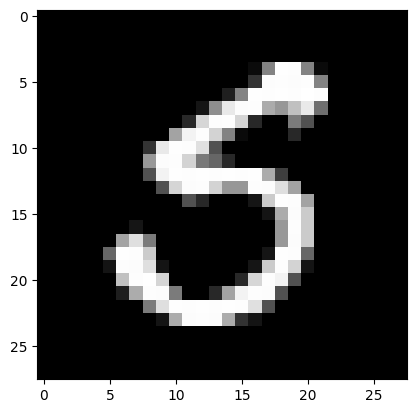

In [40]:
test_pred(0, W1, b1, W2, b2)

Prediction:  [8]
Label:  8


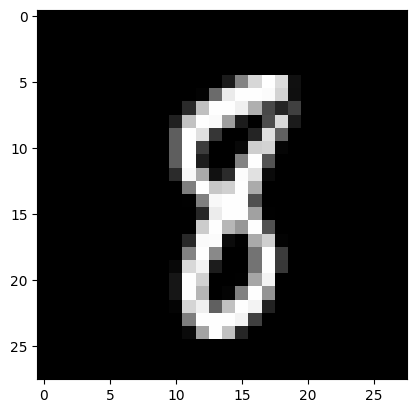

In [41]:
test_pred(2, W1, b1, W2, b2)

Prediction:  [7]
Label:  7


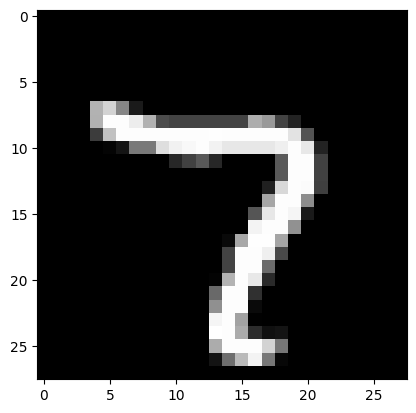

In [42]:
test_pred(3, W1, b1, W2, b2)

Prediction:  [3]
Label:  3


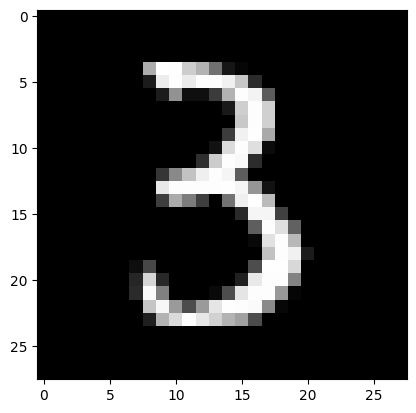

In [43]:
test_pred(5, W1, b1, W2, b2)

In [44]:
pred = make_pred(X_test, W1, b1, W2, b2)
accuracy = get_accuracy(pred, Y_test)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 91.5%
